In [1]:
# PyTorch의 핵심 라이브러리를 불러옴.
import torch
# 신경망 레이어(nn) 모듈을 불러옴.
import torch.nn as nn

# NumPy 라이브러리를 np 별칭 없이 불러옴. 배열 및 수치 연산에 사용함.
import numpy as np

# 진행 상황 표시줄(progress bar)을 구현하는 tqdm 라이브러리를 불러옴. (학습 루프 시 유용함)
from tqdm import tqdm
# 텐서 이미지를 파일로 저장하는 유틸리티 함수를 불러옴.
from torchvision.utils import save_image, make_grid

In [3]:
# --- 모델 하이퍼파라미터 설정 ---

# 데이터셋이 저장된 경로를 정의함.
dataset_path = '/content/datasets'

# CUDA(GPU) 사용 가능 여부를 나타내는 플래그를 정의함. (True로 설정)
cuda = True
# PyTorch가 사용할 장치(GPU 또는 CPU)를 결정함.
DEVICE = torch.device("cuda" if cuda else "cpu")


# 학습 시 사용할 미니 배치(batch) 크기를 100으로 설정함.
batch_size = 100

# 입력 데이터(예: 평탄화된 MNIST 이미지)의 차원을 784로 설정함.
# 이미지 (28*28) 펼친 크기
x_dim = 784
# 인코더/디코더의 은닉층(hidden layer) 차원을 400으로 설정함.
# 압축과정의 중간 단계
hidden_dim = 400
# 잠재 공간(latent space)의 차원을 200으로 설정함.
# 이미지를 압축한 최종 표현
latent_dim = 200

# 옵티마이저의 학습률(learning rate)을 1e-3 (0.001)로 설정함.
lr = 1e-3

# 총 학습 에폭(epoch) 횟수를 30으로 설정함.
epochs = 30

###    Step 1. Load (or download) Dataset

In [4]:
# TorchVision에서 MNIST 데이터셋을 불러옴.
from torchvision.datasets import MNIST
# 이미지 변환(transforms) 모듈을 불러옴.
import torchvision.transforms as transforms
# 데이터를 배치 단위로 효율적으로 로드하는 DataLoader를 불러옴.
from torch.utils.data import DataLoader


# MNIST 이미지에 적용할 전처리 파이프라인을 정의함.
mnist_transform = transforms.Compose([
    # 이미지를 PyTorch 텐서(Tensor)로 변환함.
    transforms.ToTensor(),
])

# DataLoader에 전달할 추가 인수를 정의함. num_workers는 데이터 로딩 병렬화, pin_memory는 GPU 가속에 사용함.
kwargs = {'num_workers': 1, 'pin_memory': True}

# 학습 데이터셋(MNIST)을 로드함. 변환을 적용하고, 다운로드가 필요하면 수행함.
train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# 테스트 데이터셋(MNIST)을 로드함.
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

# 학습 데이터 로더를 생성함. 배치 크기, 데이터 섞기(shuffle), 추가 인수를 적용함.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# 테스트 데이터 로더를 생성함. 평가 시에는 데이터 섞기를 비활성화함.
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.71MB/s]


### Step 2. Define our model: Variational AutoEncoder (VAE)

VAE 인코더 역할

- 이미지 >> 확률 분포로 변환
- 인코더 : 이미지 단순 압축이 아니예요. 평균, 분산(표준편차의 제곱) 가진 확률 분포 변환

- 예를 들어, 일반적으로 사진을 압축한다고 하면 ZIP 파일(고정되어 있는 결과), 반면에 VAE 압축은 사진에 속하는 내용물(레시피) + 변형 가능한 범위(분포) >> 확률적 결과

- 로그 분산 (log_var)
  - 수치 안정성 : 분산은 항상 양수, 로그 쓰면 음수도 가능
  - 계산 효율: 지수 계산 >> 로그 계산(안정적)

In [9]:
# VAE 인코더 클래스를 정의함.
class Encoder(nn.Module):

    # 모델의 레이어들을 정의하여 초기화함. input_dim, hidden_dim, latent_dim을 입력받음.
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        # 첫 번째 완전 연결(FC) 레이어를 정의함. 입력 차원에서 은닉층 차원으로 변환함.
        self.FC_input = nn.Linear(input_dim, hidden_dim)   # 784 >> 400
        # 두 번째 완전 연결 레이어를 정의함. 은닉층 차원을 유지함.
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim) # 400 >> 400
        # 잠재 공간의 평균(mean)을 출력하는 레이어를 정의함.
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)   # 400 >> 200 (평균)
        # 잠재 공간의 로그 분산(log_var)을 출력하는 레이어를 정의함.
        self.FC_var = nn.Linear (hidden_dim, latent_dim)   # 400 >> 200 (분산: 데이터 퍼진 정도)

        # Leaky ReLU 활성화 함수를 정의함.
        self.LeakyReLU = nn.LeakyReLU(0.2)

        # 모델의 현재 모드를 추적하는 플래그를 정의했음. (nn.Module에 내장되어 있지만 명시적으로 설정함)
        self.training = True

    # 데이터의 순전파 경로를 정의함.
    def forward(self, x):
        # 첫 번째 FC 레이어를 통과시키고 Leaky ReLU를 적용함.
        h_ = self.LeakyReLU(self.FC_input(x))
        # 두 번째 FC 레이어를 통과시키고 Leaky ReLU를 적용함.
        h_ = self.LeakyReLU(self.FC_input2(h_))
        # 은닉층 출력을 평균(mean) 레이어에 통과시켜 잠재 공간의 평균을 얻음.
        mean = self.FC_mean(h_)
        # 은닉층 출력을 로그 분산(log_var) 레이어에 통과시켜 잠재 공간의 로그 분산을 얻음.
        log_var = self.FC_var(h_)

        # 계산된 평균과 로그 분산 값을 반환함.
        return mean, log_var

In [8]:
# VAE 디코더 클래스를 정의함.
# >> 잠재벡터(latent_dim >> 이미지 복원)
class Decoder(nn.Module):
    # 모델의 레이어들을 정의하여 초기화함. latent_dim, hidden_dim, output_dim을 입력받음.
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        # 첫 번째 완전 연결(FC) 레이어를 정의함. 잠재 공간 차원에서 은닉층 차원으로 변환함.
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)                 # 200 >> 400
        # 두 번째 완전 연결 레이어를 정의함. 은닉층 차원을 유지함.
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)                 # 400 >> 400
        # 최종 출력 이미지 차원(output_dim)으로 변환하는 레이어를 정의함.
        self.FC_output = nn.Linear(hidden_dim, output_dim)                  # 400 >> 784

        # Leaky ReLU 활성화 함수를 정의함.
        self.LeakyReLU = nn.LeakyReLU(0.2)

    # 데이터의 순전파 경로를 정의함.
    def forward(self, x):
        # 첫 번째 FC 레이어를 통과시키고 Leaky ReLU를 적용함.
        h = self.LeakyReLU(self.FC_hidden(x))
        # 두 번째 FC 레이어를 통과시키고 Leaky ReLU를 적용함.
        h = self.LeakyReLU(self.FC_hidden2(h))

        # 최종 FC 레이어를 통과시킨 후 Sigmoid 함수를 적용함.
        # Sigmoid는 출력 픽셀 값을 [0, 1] 범위로 제한하여 이미지를 복원함.
        # >> MNIST 픽셀값 범위 tensor [0,1]
        x_hat = torch.sigmoid(self.FC_output(h))

        # 복원된 이미지 텐서(x_hat)를 반환함.
        return x_hat

In [10]:
# VAE 전체 모델 클래스를 정의함.(**)
class Model(nn.Module):
    # 인코더와 디코더 인스턴스를 받아서 초기화함.
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        # 인코더 모듈을 저장함.
        self.Encoder = Encoder
        # 디코더 모듈을 저장함.
        self.Decoder = Decoder

    # 잠재 벡터(z)를 추출하기 위한 재매개변수화 트릭을 구현함.
    # 왜??
    # 샘플링이 확률적이여서 역전파가 불가능하여 결정론적 계산으로 변환해 줘야 함
    # z ~ N(mu,var) (샘플링, 역전파 불가),
    # z = mu + sigma * epsilon, where epsilon ~ N(0,1) (계산, 역전파 가능)
    # 기본값 + (랜덤값 * 범위)
    def reparameterization(self, mean, var):
        # 표준 정규 분포에서 epsilon(노이즈)을 샘플링하고 현재 장치(DEVICE)로 이동시킴.
        epsilon = torch.randn_like(var).to(DEVICE)
        # z = 평균 + 표준편차 * epsilon 공식으로 잠재 벡터 z를 계산함. (재매개변수화 트릭)
        z = mean + var*epsilon
        # 샘플링된 잠재 벡터 z를 반환함.
        return z


    # 데이터의 순전파 경로를 정의함.
    def forward(self, x):
        # 인코더를 통해 평균(mean)과 로그 분산(log_var)을 얻음.
        mean, log_var = self.Encoder(x)

        # 로그 분산(log_var)을 분산(var)의 표준편차(std)로 변환함: exp(0.5 * log_var)
        # 이 값을 사용하여 재매개변수화 함수에서 잠재 벡터 z를 샘플링함.
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))

        # 샘플링된 잠재 벡터 z를 디코더에 통과시켜 복원된 이미지(x_hat)를 얻음.
        x_hat = self.Decoder(z)

        # 복원된 이미지(x_hat), 평균, 로그 분산 값을 반환함.
        return x_hat, mean, log_var

In [11]:
# Encoder 클래스를 사용하여 인코더 인스턴스를 생성함.
# 하이퍼파라미터(x_dim, hidden_dim, latent_dim)를 전달했음.
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

# Decoder 클래스를 사용하여 디코더 인스턴스를 생성함.
# 하이퍼파라미터(latent_dim, hidden_dim, x_dim)를 전달했음.
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

# Encoder와 Decoder 인스턴스를 사용하여 VAE Model 클래스의 최종 모델 인스턴스를 생성함.
# 생성된 모델을 정의된 장치(DEVICE, GPU 또는 CPU)로 이동시켰음.
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [13]:
# PyTorch의 Adam 옵티마이저를 불러옴.
from torch.optim import Adam

# 이진 교차 엔트로피 손실 함수(BCELoss) 모듈을 정의함.
BCE_loss = nn.BCELoss()

# VAE의 복합 손실 함수를 정의함.
def loss_function(x, x_hat, mean, log_var):
    # 1. 재구성 손실(Reconstruction Loss)을 계산함. (BCE 사용)
    # 원본 이미지와 VAE로 복원된 이미지 차이(얼마나 잘 복원되었나?)
    # 복원된 이미지(x_hat)와 원본 이미지(x) 사이의 이진 교차 엔트로피를 계산함. reduction='sum'으로 합산함.
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # 2. 쿨백-라이블러 발산(KLD, KL Divergence) 손실을 계산함.
    # 인코딩된 잠재 분포와 표준 정규 분포 사이의 차이를 측정함.
    # KL 결과 해석)
    # 평균이 0에서 멀어질수록, 분산(표준편차(평균에서 떨어진 것)의 제곱)이 1에서 멀어질 수록
    # >> 손해(LOSS) 우리는 손해를 싫어해요 >> 목표 N(normalize) (0,1)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # 총 손실은 재구성 손실과 KLD 손실의 합으로 정의됨.
    return reproduction_loss + KLD


# VAE 모델의 모든 파라미터에 대해 Adam 옵티마이저를 정의함. 학습률(lr)을 사용함.
optimizer = Adam(model.parameters(), lr=lr)

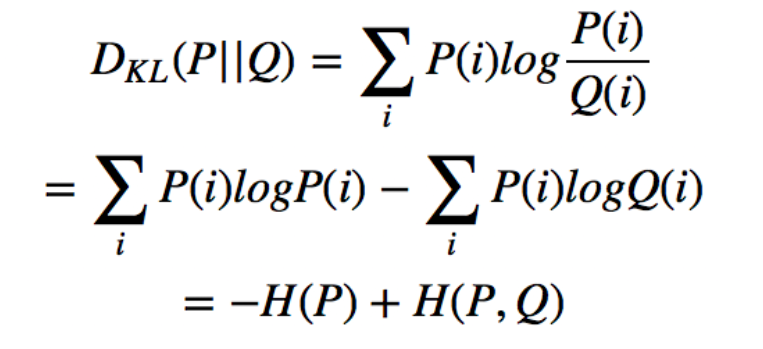

### Step 4. Train Variational AutoEncoder (VAE)

In [14]:
# VAE 학습 시작 메시지를 출력함.
print("Start training VAE...")

# 모델을 학습 모드로 설정함.
model.train()

# 정의된 에폭 수(epochs)만큼 학습을 반복함.
for epoch in range(epochs):
    # 현재 에폭의 누적 손실을 0으로 초기화함.
    overall_loss = 0

    # 학습 데이터 로더를 순회하며 미니 배치(x, 레이블 무시)를 처리함.
    for batch_idx, (x, _) in enumerate(train_loader):
        # 입력 이미지 텐서를 [배치 크기, 784] 크기로 평탄화(flatten)함.
        x = x.view(batch_size, x_dim)
        # 텐서를 정의된 장치(DEVICE, GPU/CPU)로 이동시킴.
        x = x.to(DEVICE)

        # 옵티마이저의 변화도(gradient)를 0으로 초기화함.
        optimizer.zero_grad()

        # 모델 순전파를 수행하여 복원된 이미지(x_hat), 평균(mean), 로그 분산(log_var)을 얻음.
        x_hat, mean, log_var = model(x)

        # 정의된 VAE 손실 함수(재구성 손실 + KLD)를 계산함.
        loss = loss_function(x, x_hat, mean, log_var)

        # 현재 배치의 손실 값을 전체 누적 손실에 더함.
        overall_loss += loss.item()

        # 역전파를 수행하여 변화도를 계산함.
        loss.backward()

        # 옵티마이저를 사용하여 모델 파라미터를 업데이트함.
        optimizer.step()

    # 현재 에폭이 완료된 후 평균 손실을 계산하여 출력함.
    # (batch_idx * batch_size)는 처리된 총 샘플 수에 근접한 값임.
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

# 전체 학습이 완료되었음을 출력함.
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  175.59067100766904
	Epoch 2 complete! 	Average Loss:  129.2176881553892
	Epoch 3 complete! 	Average Loss:  118.27180261373123
	Epoch 4 complete! 	Average Loss:  113.30419095302067
	Epoch 5 complete! 	Average Loss:  110.10490063191256
	Epoch 6 complete! 	Average Loss:  108.19740025693865
	Epoch 7 complete! 	Average Loss:  107.02067638772955
	Epoch 8 complete! 	Average Loss:  106.1172670596828
	Epoch 9 complete! 	Average Loss:  105.44321652624166
	Epoch 10 complete! 	Average Loss:  104.79304113626878
	Epoch 11 complete! 	Average Loss:  104.35705301479028
	Epoch 12 complete! 	Average Loss:  103.91207252973706
	Epoch 13 complete! 	Average Loss:  103.59284469884703
	Epoch 14 complete! 	Average Loss:  103.22977570038606
	Epoch 15 complete! 	Average Loss:  102.95334026763355
	Epoch 16 complete! 	Average Loss:  102.71990387625209
	Epoch 17 complete! 	Average Loss:  102.38784642698769
	Epoch 18 complete! 	Average Loss:  102.1196989285528


### Step 5. Generate images from test dataset

In [15]:
import matplotlib.pyplot as plt

In [16]:
# 모델을 평가 모드로 설정함. (Dropout, BatchNorm 등의 동작을 평가에 맞게 변경함)
model.eval()

# 변화도(gradient) 추적을 비활성화함. 평가 시 메모리를 절약하고 속도를 높임.
with torch.no_grad():
    # 테스트 데이터 로더를 순회하며 미니 배치(x, 레이블 무시)를 처리함.
    # tqdm은 루프의 진행 상황을 시각적으로 표시함.
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        # 입력 이미지 텐서를 [배치 크기, 784] 크기로 평탄화함.
        x = x.view(batch_size, x_dim)
        # 텐서를 정의된 장치(DEVICE, GPU/CPU)로 이동시킴.
        x = x.to(DEVICE)

        # 모델 순전파를 수행하여 복원된 이미지(x_hat)를 얻음.
        # 평가 모드이므로 평균과 로그 분산은 무시함.
        x_hat, _, _ = model(x)


        # 첫 번째 배치만 처리하고 루프를 종료함.
        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [17]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

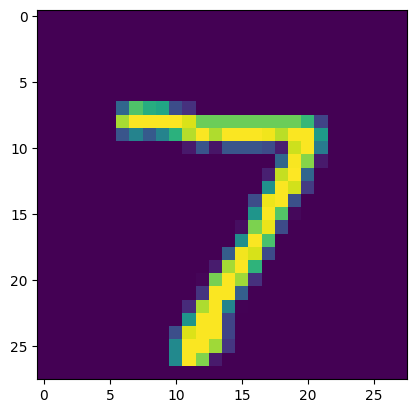

In [18]:
show_image(x, idx=0)

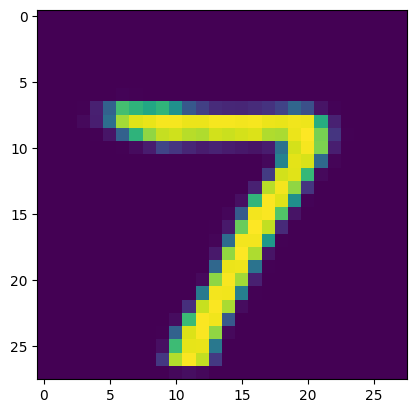

In [ ]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

VAE 학습 시 사용되는 손실 함수가 사후분포 $q(z|x)$ (단순하고 다루기 쉬운 사후분포)를 표준 정규 분포 $\mathcal{N}(0, I)$에 충분히 가깝게 규제하기 때문에, 우리는 실제 $p(z|x)$를 정확히 알지 못하더라도 노이즈로부터 이미지를 생성할 수 있습니다.      
만약 $q(z|x)$가 $\mathcal{N}(0, I)$에 "충분히 가깝다면" (다만, 후기 분포 붕괴(posterior collapse) 문제로 인해 완벽하게 가깝지는 않을 수 있습니다), $\mathcal{N}(0, I)$는 VAE의 인코더를 대체할 수 있습니다.    
이를 보여주기 위해, 저는 **GAN(생성적 적대 신경망)**과 유사하게 $\mathcal{N}(0, I)$에서 샘플링된 노이즈 벡터를 사용해 방금 테스트를 수행했습니다.

In [19]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    # 표준 정규분포에서 노이즈 샘플링
    generated_images = decoder(noise)

In [20]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

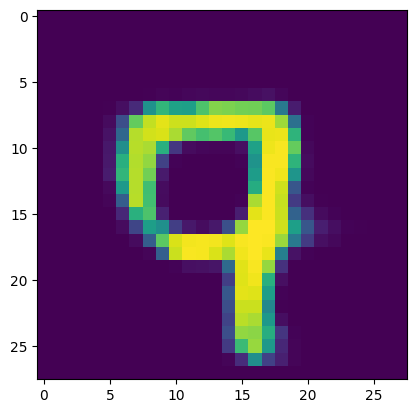

In [21]:
show_image(generated_images, idx=12)

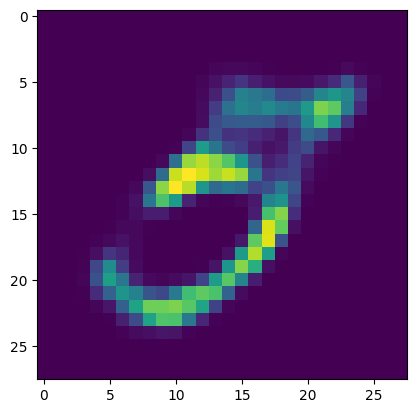

In [22]:
show_image(generated_images, idx=0)

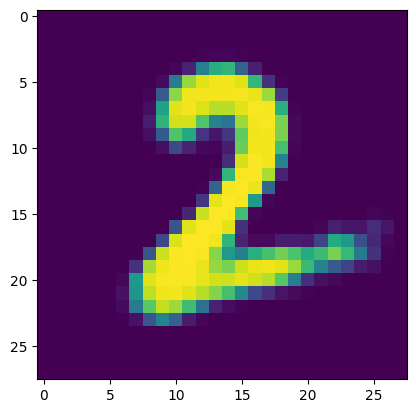

In [23]:
show_image(generated_images, idx=1)

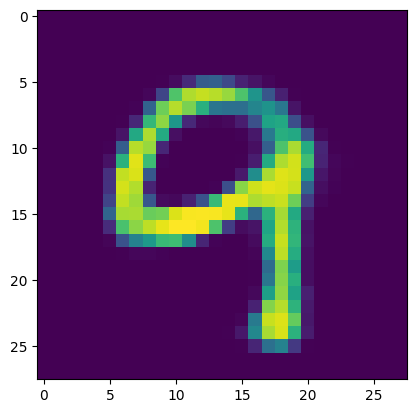

In [24]:
show_image(generated_images, idx=10)

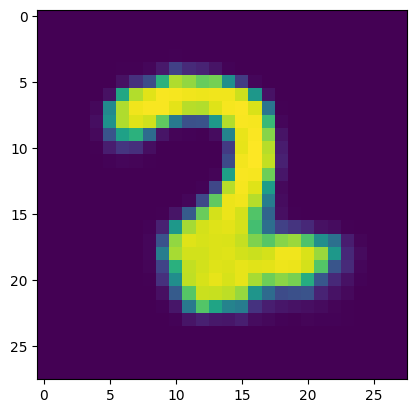

In [25]:
show_image(generated_images, idx=20)

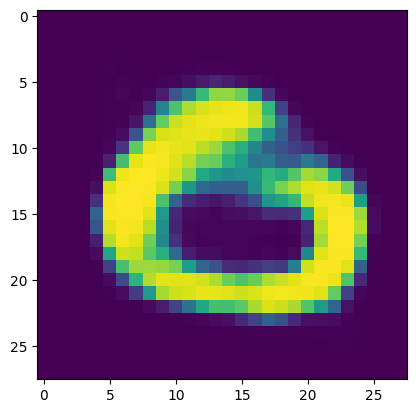

In [26]:
show_image(generated_images, idx=50)

In [ ]:
# EOS